In [1]:
import gpflow
import numpy as np
import matplotlib
import pandas as pd
from sklearn.metrics import mean_squared_error
from gpflow.utilities import print_summary, set_trainable, to_default_float

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

I am using gpflow for GP modeling/inference. For instructions and more examples see\

https://gpflow.github.io/GPflow/develop/index.html

To improve optimization in some cases you may need to try: 
1) Multiple restarts;\
2) Assigning a reasonable (possible informative) prior;\
3) To automate this you may design a convergence diagnistic measure. 

### Load the example data 

In [2]:
data1 = pd.read_csv('data/data1.csv')
data2 = pd.read_csv('data/data2.csv')
data3 = pd.read_csv('data/data3.csv')

data1 = data1.sort_values('X')
data2 = data2.sort_values('X')
data3 = data3.sort_values('X')

### When testing the model you can try to remove part of data -- see how it affects the optimization, uncertainty etc.

In [3]:
## Remove part of the data to play around with the fit; 
## See what happens with uncertainty.
#data1 = data1.drop(data1.index[range(10,15)])
#data2 = data2.drop(data2.index[range(10,15)])
#data3 = data3.drop(data3.index[range(10,15)])

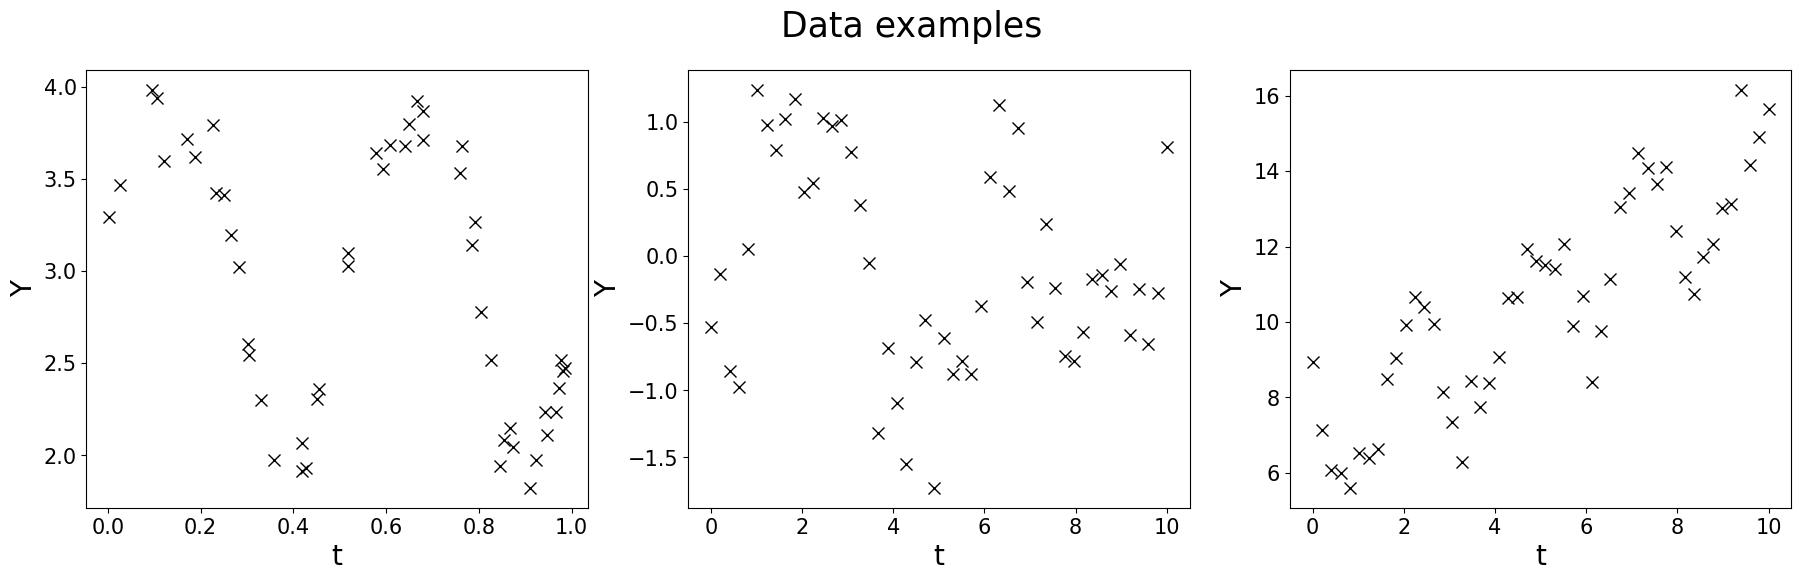

In [4]:
matplotlib.rcParams['figure.figsize'] = (22, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Data examples', fontsize=25)

ax1.plot(data1['X'], data1['Y'], 'kx', markersize=8)
ax2.plot(data2['X'], data2['Y'], 'kx', markersize=8)
ax3.plot(data3['X'], data3['Y'], 'kx', markersize=8)

ax1.set_xlabel('t', fontsize = 20.0) 
ax1.set_ylabel('Y', fontsize = 20.0) 
ax2.set_xlabel('t', fontsize = 20.0) 
ax2.set_ylabel('Y', fontsize = 20.0) 
ax3.set_xlabel('t', fontsize = 20.0) 
ax3.set_ylabel('Y', fontsize = 20.0) 


ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)

plt.subplots_adjust(bottom=0.15)

plt.savefig('figures/DataExamples.png')

### Analyze data set 1

In [1]:
X = data1['X'].to_numpy().reshape(-1,1)
Y = data1['Y'].to_numpy().reshape(-1,1)

NameError: name 'data1' is not defined

Define the kernel

In [6]:
#k = gpflow.kernels.Bias() + gpflow.kernels.Linear() # Equivalent of Bayesian linear regresion
k = gpflow.kernels.Matern52() # non-stationaty
#k = gpflow.kernels.RBF(lengthscales=0.1) # smooth
#k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=1.0) # periodic with a base kernel being smooth

Metal device set to: Apple M1 Pro


2023-11-02 10:50:30.830600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 10:50:30.830641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# To compute covariance
#k(X,X)

Define the model (GPR - Gaussian processes regression)

In [8]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

### Optimize the model

In [9]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return m.training_loss()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-11-02 10:50:32.589882: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-02 10:50:32.590259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.10142 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.27172 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.01225 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

Compute posterior predictive distribution; \
provides two quantities: mean and variance;\
the mean of 'all possible' functions;\
the variance of thereof, i.e. confidence intervals can be constructed using it; \
samples - samples from the posterior (i.e. remember -- we are doing Bayesian inference).

In [10]:
## generate test points for prediction
xx = np.linspace(-0.1, 1.5, 100).reshape(100, 1)  # test points must be of shape (N, D)
## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)
## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

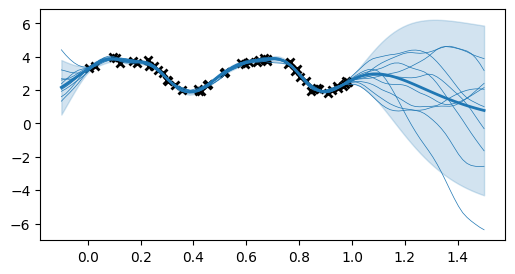

In [11]:
## plot
plt.figure(figsize=(6, 3))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

### Compute mean suared error of the fit

In [12]:
Y_pred, Var_pred = m.predict_f(X)
mean_squared_error(Y,Y_pred)

0.008757997109476476

### Analyze data set 2

In [13]:
X = data2['X'].to_numpy().reshape(-1,1)
Y = data2['Y'].to_numpy().reshape(-1,1)

In [14]:
#k = gpflow.kernels.Bias() + gpflow.kernels.Linear() # Equivalent of Bayesian linear regresion
k = gpflow.kernels.Matern52()
#k = gpflow.kernels.RBF(lengthscales=0.1)
#k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=1.0)

In [15]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [16]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return m.training_loss()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.46974 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.58029 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.13473 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

2023-11-02 10:50:34.673899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


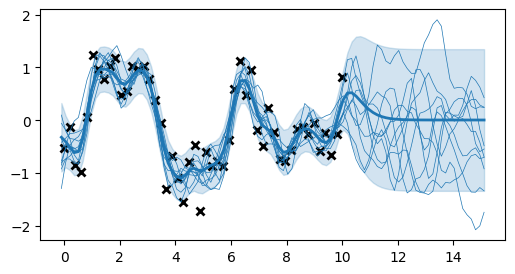

In [17]:
## generate test points for prediction
xx = np.linspace(-0.1, 15.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(6, 3))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

### Compute mean suared error of the fit

In [18]:
Y_pred, Var_pred = m.predict_f(X)
mean_squared_error(Y,Y_pred)

0.08606264962679706

### Analyze data set 3

In [19]:
X = data3['X'].to_numpy().reshape(-1,1)
Y = data3['Y'].to_numpy().reshape(-1,1)

In [20]:
k = gpflow.kernels.Matern52()
#k = gpflow.kernels.RBF(lengthscales=1.1)
## Below are the same kernels, just different initializations
k = gpflow.kernels.Periodic(gpflow.kernels.Matern52(lengthscales=1), period=2.0)+gpflow.kernels.Linear(1.0) 
#k = gpflow.kernels.Periodic(gpflow.kernels.Matern52(lengthscales=2), period=2.0)+gpflow.kernels.Linear(1.0)
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [21]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return m.training_loss()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

2023-11-02 10:50:35.886492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 84.5302  │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  5.62983 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].period           

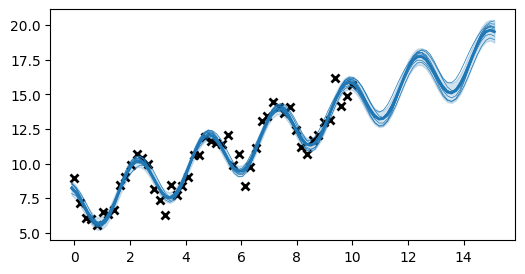

In [22]:
## generate test points for prediction
xx = np.linspace(-0.1, 15.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(6, 3))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

### Compute mean suared error of the fit

In [23]:
Y_pred, Var_pred = m.predict_f(X)
mean_squared_error(Y,Y_pred)

0.45786812293525636

### Figure from the lecture

In [24]:
X1 = data1['X'].to_numpy().reshape(-1,1)
Y1 = data1['Y'].to_numpy().reshape(-1,1)

X2 = data2['X'].to_numpy().reshape(-1,1)
Y2 = data2['Y'].to_numpy().reshape(-1,1)

X3 = data3['X'].to_numpy().reshape(-1,1)
Y3 = data3['Y'].to_numpy().reshape(-1,1)

In [25]:
k1 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=1.0) # periodic with a base kernel being smooth
k2 = gpflow.kernels.Matern52()
k3 = gpflow.kernels.Periodic(gpflow.kernels.Matern52(lengthscales=1), period=2.0)+gpflow.kernels.Linear(1.0) 

In [26]:
m1 = gpflow.models.GPR(data=(X1, Y1), kernel=k1, mean_function=None)
m2 = gpflow.models.GPR(data=(X2, Y2), kernel=k2, mean_function=None)
m3 = gpflow.models.GPR(data=(X3, Y3), kernel=k3, mean_function=None)

In [27]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return m1.training_loss()

opt_logs = opt.minimize(objective_closure,
                        m1.trainable_variables,
                        options=dict(maxiter=100))

def objective_closure():
    return m2.training_loss()

opt_logs = opt.minimize(objective_closure,
                        m2.trainable_variables,
                        options=dict(maxiter=100))

def objective_closure():
    return m3.training_loss()

opt_logs = opt.minimize(objective_closure,
                        m3.trainable_variables,
                        options=dict(maxiter=100))

2023-11-02 10:50:37.162350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 10:50:37.488894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 10:50:37.709390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


You can use predict_f() if you want to predictions without the estimates of the noise, i.e. only for the f() itself. If you want to add predictions for the noise in the regression model, use predict_y().

In [28]:
## generate test points for prediction
xx1 = np.linspace(-0.1, 1.5, 100).reshape(100, 1)  # test points must be of shape (N, D)
## predict mean and variance of latent GP at test points
#mean1, var1 = m1.predict_f(xx1)
mean1, var1 = m1.predict_y(xx1)
## generate 10 samples from posterior
samples1 = m1.predict_f_samples(xx1, 10)  # shape (10, 100, 1)

## generate test points for prediction
xx2 = np.linspace(-0.1, 11.1, 100).reshape(100, 1)  # test points must be of shape (N, D)
## predict mean and variance of latent GP at test points
#mean2, var2 = m2.predict_f(xx2)
mean2, var2 = m2.predict_y(xx2)
## generate 10 samples from posterior
samples2 = m2.predict_f_samples(xx2, 10)  # shape (10, 100, 1)

## generate test points for prediction
xx3 = np.linspace(-0.1, 15.1, 100).reshape(100, 1)  # test points must be of shape (N, D)
## predict mean and variance of latent GP at test points
#mean3, var3 = m.predict_f(xx3)
mean3, var3 = m3.predict_y(xx3)
## generate 10 samples from posterior
samples3 = m3.predict_f_samples(xx3, 10)  # shape (10, 100, 1)

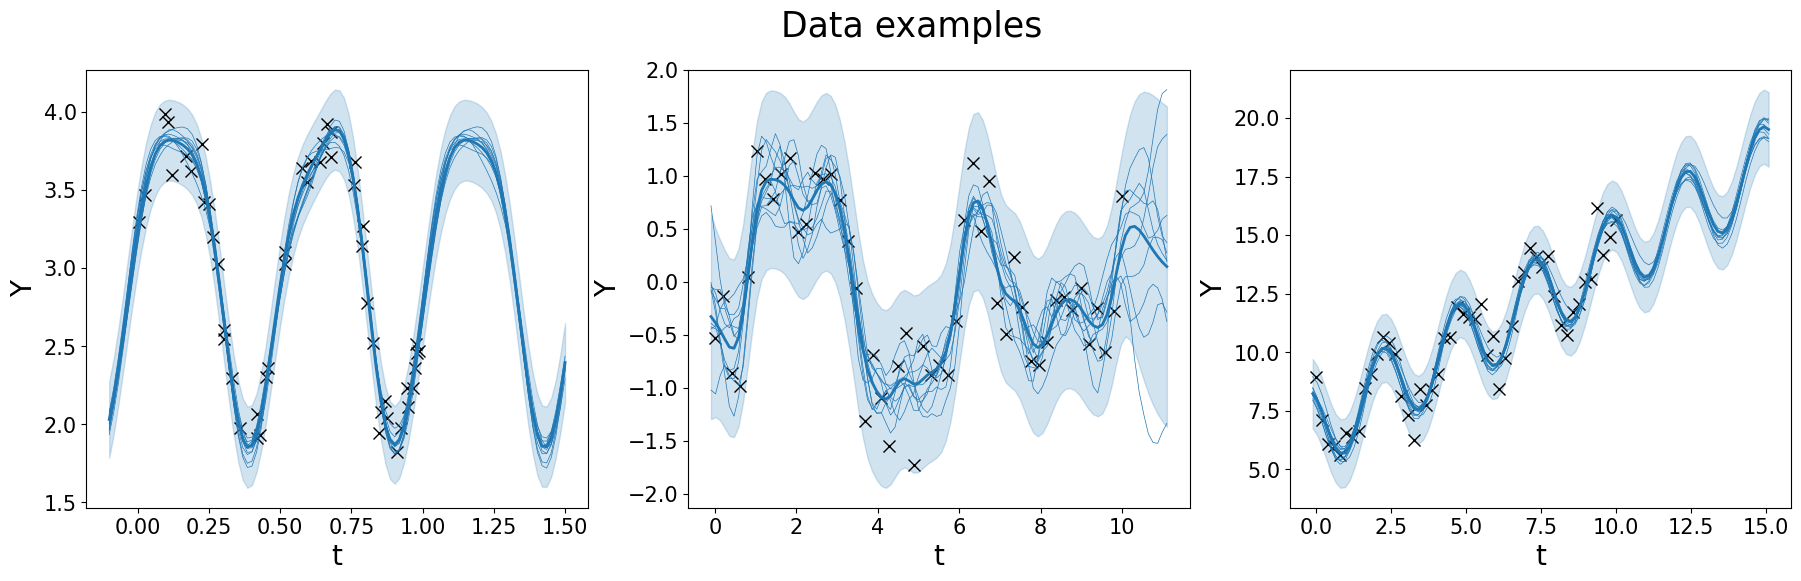

In [29]:
matplotlib.rcParams['figure.figsize'] = (22, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Data examples', fontsize=25)

ax1.plot(data1['X'], data1['Y'], 'kx', markersize=8)
ax1.plot(xx1, mean1, 'C0', lw=2)
ax1.fill_between(xx1[:,0],
                 mean1[:,0] - 1.96 * np.sqrt(var1[:,0]),
                 mean1[:,0] + 1.96 * np.sqrt(var1[:,0]),
                 color='C0', alpha=0.2)
ax1.plot(xx1, samples1[:, :, 0].numpy().T, 'C0', linewidth=.5)

ax2.plot(data2['X'], data2['Y'], 'kx', markersize=8)
ax2.plot(xx2, mean2, 'C0', lw=2)
ax2.fill_between(xx2[:,0],
                 mean2[:,0] - 1.96 * np.sqrt(var2[:,0]),
                 mean2[:,0] + 1.96 * np.sqrt(var2[:,0]),
                 color='C0', alpha=0.2)
ax2.plot(xx2, samples2[:, :, 0].numpy().T, 'C0', linewidth=.5)


ax3.plot(data3['X'], data3['Y'], 'kx', markersize=8)
ax3.plot(xx3, mean3, 'C0', lw=2)
ax3.fill_between(xx3[:,0],
                 mean3[:,0] - 1.96 * np.sqrt(var3[:,0]),
                 mean3[:,0] + 1.96 * np.sqrt(var3[:,0]),
                 color='C0', alpha=0.2)
ax3.plot(xx3, samples3[:, :, 0].numpy().T, 'C0', linewidth=.5)


ax1.set_xlabel('t', fontsize = 20.0) 
ax1.set_ylabel('Y', fontsize = 20.0) 
ax2.set_xlabel('t', fontsize = 20.0) 
ax2.set_ylabel('Y', fontsize = 20.0) 
ax3.set_xlabel('t', fontsize = 20.0) 
ax3.set_ylabel('Y', fontsize = 20.0) 


ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)

plt.subplots_adjust(bottom=0.15)

plt.savefig('figures/DataExamples_fits.png')